In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa
import os
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
data_de, sample_rate_de = librosa.load('../data/test_data/test_audio_telugu_1.mp3')

print(f'Audio for Language: Telugu')
print(f'Audio Data Sample Rate: {sample_rate_de}')
print(f'Audio Data: {data_de}')

ipd.Audio(data=data_de, rate=sample_rate_de)

Audio for Language: Telugu
Audio Data Sample Rate: 22050
Audio Data: [ 2.1537330e-06 -3.0066044e-06  9.3615233e-07 ...  3.7065480e-04
  3.5918615e-04  1.6044824e-04]


In [3]:
test_data_path = '../data/test_data/'

In [4]:
def load_data(file_name: str) -> tuple:
    """Loads audio data from a file using librosa.

    Parameters:
        file_name (str): Path to the audio file.

    Returns:
        tuple: A tuple containing the sample rate and duration of the audio in seconds.
               If an error occurs during processing, returns (np.nan, np.nan).
    """

    try:
        # Load audio data and sample rate
        audio_data, sample_rate = librosa.load(file_name, sr=22050)

        # Calculate duration of audio in seconds
        audio_duration_sec = int(librosa.get_duration(y=audio_data, sr=sample_rate))

        return (sample_rate, audio_duration_sec)

    except Exception as e:
        # Print error message if an exception occurs during processing
        print(f"Error processing {file_name}: {str(e)}")

        # Return NaN values for sample rate and duration
        return (np.nan, np.nan)

In [5]:
test_language_dataframe = pd.DataFrame({'file_name': [test_data_path + file_name for file_name in os.listdir(test_data_path)]})

test_language_dataframe['language_label'] = test_language_dataframe['file_name'].str.split('_', expand=True).iloc[:, 3]
test_language_dataframe['file_size_kb'] = (test_language_dataframe['file_name'].apply(lambda x: os.path.getsize(x)) / 1024).round(3)

test_language_dataframe[['sample_rate', 'audio_duration_sec']] = test_language_dataframe['file_name'].apply(lambda file_name: pd.Series(load_data(file_name=file_name)))
test_language_dataframe = test_language_dataframe[test_language_dataframe['audio_duration_sec'] >= 10]
test_language_dataframe.to_csv('../data/model_data/test_language_dataframe_v1.csv', index=False)

test_language_dataframe

,file_name,language_label,file_size_kb,sample_rate,audio_duration_sec
0,../data/test_data/test_audio_bengali_1.flac,bengali,185.367,22050,10
1,../data/test_data/test_audio_english_1.flac,english,208.781,22050,10
2,../data/test_data/test_audio_english_2.flac,english,165.432,22050,10
3,../data/test_data/test_audio_english_3.mp3,english,23.742,22050,10
4,../data/test_data/test_audio_english_4.mp3,english,24.566,22050,10
5,../data/test_data/test_audio_german_1.flac,german,230.990,22050,10
6,../data/test_data/test_audio_german_2.flac,german,226.154,22050,10
7,../data/test_data/test_audio_gujarati_1.flac,gujarati,218.465,22050,10
8,../data/test_data/test_audio_gujarati_2.mp3,gujarati,23.964,22050,10
9,../data/test_data/test_audio_hindi_1.flac,hindi,232.983,22050,10


In [6]:
test_language_dataframe = pd.read_csv('../data/model_data/test_language_dataframe_v1.csv')

In [7]:
def extract_features_mean(file_name: str) -> np.ndarray:
    audio_data, sample_rate = librosa.load(file_name)

    mfcc_feat = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)[:, :431]
    zero_crossing_rate_feat = librosa.feature.zero_crossing_rate(audio_data)[:, :431]

    mag_s, _ = librosa.magphase(librosa.stft(audio_data))
    spectral_rolloff_feat = librosa.feature.spectral_rolloff(S=mag_s, sr=sample_rate)[:, :431]

    onset_strength_feat = librosa.onset.onset_strength(y=audio_data, sr=sample_rate)[:431].reshape(1, 431)
    rms_feat = librosa.feature.rms(y=audio_data)[:, :431]

    power_spec = np.abs(librosa.stft(audio_data))**2
    norm_power_spec = power_spec / np.sum(power_spec, axis=0, keepdims=True)
    spectral_entropy_feat = -np.sum(norm_power_spec * np.log2(norm_power_spec), axis=0)[:431].reshape(1, 431)

    chroma_stft_feat = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)[:, :431]

    pitch_feat, _ = librosa.piptrack(y=audio_data, sr=sample_rate)
    pitch_feat = pitch_feat.mean(axis=0)[:431].reshape(1, 431)

    features_combined = np.concatenate([
        mfcc_feat, zero_crossing_rate_feat, spectral_rolloff_feat, onset_strength_feat, rms_feat,
        spectral_entropy_feat, chroma_stft_feat, pitch_feat], axis=0)[:, :431]

    features_combined[np.isnan(features_combined)] = 0

    return list(np.round(np.mean(features_combined.T, axis=0), 5))


mfcc_feature_vector = test_language_dataframe['file_name'].apply(lambda file_name: pd.Series(extract_features_mean(file_name=file_name)))
mfcc_feature_vector['language_label'] = test_language_dataframe['language_label']

mfcc_feature_vector.to_parquet('../data/model_data/test_mfcc_feature_mean_dataframe_v1.parquet', index=False)

In [8]:
test_language_dataframe = pd.read_csv('../data/model_data/test_language_dataframe_v1.csv')

In [9]:
def get_mfcc_features(file_name: str) -> tuple:
    audio_data, sample_rate = librosa.load(file_name)

    mfcc_feat = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)[:, :431]
    zero_crossing_rate_feat = librosa.feature.zero_crossing_rate(audio_data)[:, :431]

    mag_s, _ = librosa.magphase(librosa.stft(audio_data))
    spectral_rolloff_feat = librosa.feature.spectral_rolloff(S=mag_s, sr=sample_rate)[:, :431]

    onset_strength_feat = librosa.onset.onset_strength(y=audio_data, sr=sample_rate)[:431].reshape(1, 431)
    rms_feat = librosa.feature.rms(y=audio_data)[:, :431]

    power_spec = np.abs(librosa.stft(audio_data))**2
    norm_power_spec = power_spec / np.sum(power_spec, axis=0, keepdims=True)
    spectral_entropy_feat = -np.sum(norm_power_spec * np.log2(norm_power_spec), axis=0)[:431].reshape(1, 431)

    chroma_stft_feat = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)[:, :431]

    pitch_feat, _ = librosa.piptrack(y=audio_data, sr=sample_rate)
    pitch_feat = pitch_feat.mean(axis=0)[:431].reshape(1, 431)

    features_combined = np.concatenate([
        mfcc_feat, zero_crossing_rate_feat, spectral_rolloff_feat, onset_strength_feat, rms_feat,
        spectral_entropy_feat, chroma_stft_feat, pitch_feat], axis=0)[:, :431]

    features_combined[np.isnan(features_combined)] = 0

    return np.round(features_combined, 5).flatten()


mfcc_feature_vector = test_language_dataframe['file_name'].apply(lambda file_name: pd.Series(get_mfcc_features(file_name=file_name)))
mfcc_feature_vector['language_label'] = test_language_dataframe['language_label']

mfcc_feature_vector.to_parquet('../data/model_data/test_mfcc_feature_dataframe_v1.parquet', index=False)

#### Model Testing

In [10]:
X_test = pd.read_parquet('../data/model_data/test_mfcc_feature_mean_dataframe_v1.parquet')
y_test = X_test['language_label']

X_test = X_test.drop(columns=['language_label']).reset_index(drop=True).values

language_labels_cols = list(pd.get_dummies(y_test, dtype=np.int32).columns.values)

X_test = X_test.reshape(-1, 58, 1)
y_test = pd.get_dummies(y_test.values, dtype=np.int32).values

X_test.shape, y_test.shape

((21, 58, 1), (21, 12))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6190 - loss: 2.7233
[2.723280668258667, 0.6190476417541504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'bengali'),
  Text(1, 0, 'english'),
  Text(2, 0, 'german'),
  Text(3, 0, 'gujarati'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'kannada'),
  Text(6, 0, 'malayalam'),
  Text(7, 0, 'marathi'),
  Text(8, 0, 'spanish'),
  Text(9, 0, 'tamil'),
  Text(10, 0, 'telugu'),
  Text(11, 0, 'urdu')])

<Figure size 800x600 with 0 Axes>

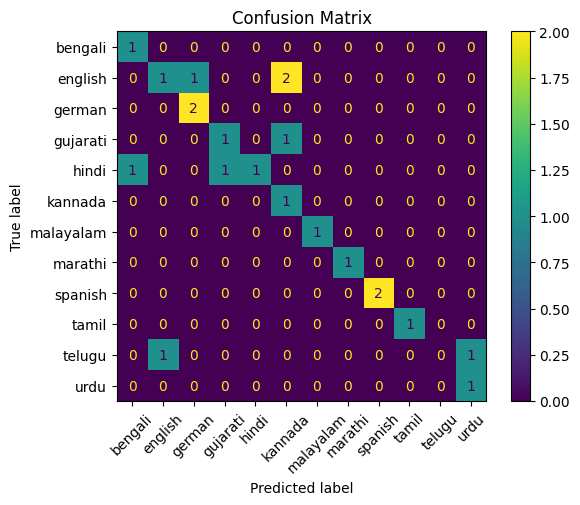

In [11]:
model = load_model('../data/models/language_detection_model_unscaled_v1.keras')
print(model.evaluate(X_test, y_test))

y_pred = model.predict(X_test)

y_test_argmax = [np.argmax(y_test[i,:]) for i in range(0, len(y_test))]
y_pred_argmax = [np.argmax(y_pred[i,:]) for i in range(0,len(y_pred))]

confusion_matrix_data = confusion_matrix(y_test_argmax, y_pred_argmax)

plt.figure(figsize = (8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=language_labels_cols)
cmd.plot()

plt.title('Confusion Matrix')
plt.xticks(rotation=45)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6190 - loss: 3.8319
[3.8318867683410645, 0.6190476417541504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'bengali'),
  Text(1, 0, 'english'),
  Text(2, 0, 'german'),
  Text(3, 0, 'gujarati'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'kannada'),
  Text(6, 0, 'malayalam'),
  Text(7, 0, 'marathi'),
  Text(8, 0, 'spanish'),
  Text(9, 0, 'tamil'),
  Text(10, 0, 'telugu'),
  Text(11, 0, 'urdu')])

<Figure size 800x600 with 0 Axes>

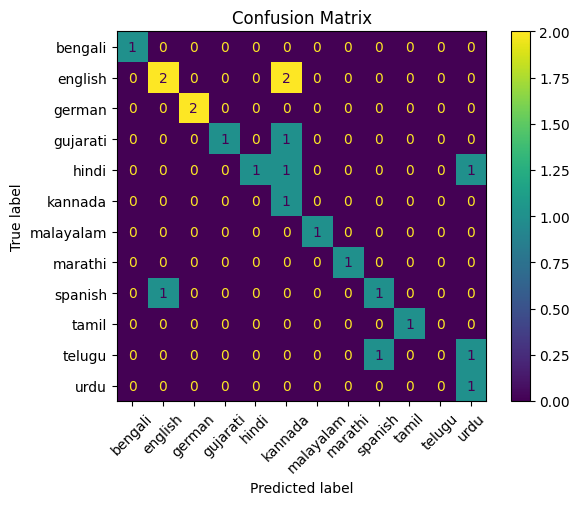

In [12]:
X_test_scaled = StandardScaler().fit_transform(X_test.reshape(-1, 58)).reshape(-1, 58, 1)

model = load_model('../data/models/language_detection_model_scaled_v1.keras')
print(model.evaluate(X_test_scaled, y_test))

y_pred = model.predict(X_test_scaled)

y_test_argmax = [np.argmax(y_test[i,:]) for i in range(0, len(y_test))]
y_pred_argmax = [np.argmax(y_pred[i,:]) for i in range(0,len(y_pred))]

confusion_matrix_data = confusion_matrix(y_test_argmax, y_pred_argmax)

plt.figure(figsize = (8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=language_labels_cols)
cmd.plot()

plt.title('Confusion Matrix')
plt.xticks(rotation=45)

#### CNN Model

In [13]:
X_test = pd.read_parquet('../data/model_data/test_mfcc_feature_dataframe_v1.parquet')
y_test = X_test['language_label']

X_test = X_test.drop(columns=['language_label']).reset_index(drop=True).values

language_labels_cols = list(pd.get_dummies(y_test, dtype=np.int32).columns.values)

X_test = X_test.reshape(-1, 58, 431, 1)
y_test = pd.get_dummies(y_test.values, dtype=np.int32).values

X_test.shape, y_test.shape

((21, 58, 431, 1), (21, 12))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.3810 - loss: 3.1699
[3.1698672771453857, 0.380952388048172]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'bengali'),
  Text(1, 0, 'english'),
  Text(2, 0, 'german'),
  Text(3, 0, 'gujarati'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'kannada'),
  Text(6, 0, 'malayalam'),
  Text(7, 0, 'marathi'),
  Text(8, 0, 'spanish'),
  Text(9, 0, 'tamil'),
  Text(10, 0, 'telugu'),
  Text(11, 0, 'urdu')])

<Figure size 800x600 with 0 Axes>

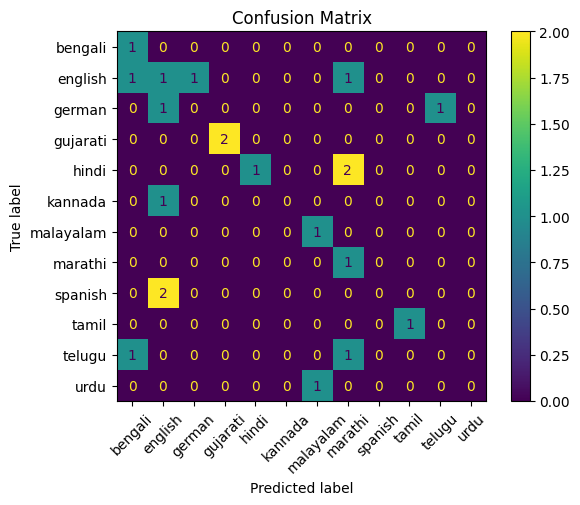

In [14]:
model = load_model('../data/models/language_detection_model_unscaled_v2.keras')
print(model.evaluate(X_test, y_test))

y_pred = model.predict(X_test)

y_test_argmax = [np.argmax(y_test[i,:]) for i in range(0, len(y_test))]
y_pred_argmax = [np.argmax(y_pred[i,:]) for i in range(0,len(y_pred))]

confusion_matrix_data = confusion_matrix(y_test_argmax, y_pred_argmax)

plt.figure(figsize = (8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=language_labels_cols)
cmd.plot()

plt.title('Confusion Matrix')
plt.xticks(rotation=45)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.4762 - loss: 14.0349
[14.03489875793457, 0.4761904776096344]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'bengali'),
  Text(1, 0, 'english'),
  Text(2, 0, 'german'),
  Text(3, 0, 'gujarati'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'kannada'),
  Text(6, 0, 'malayalam'),
  Text(7, 0, 'marathi'),
  Text(8, 0, 'spanish'),
  Text(9, 0, 'tamil'),
  Text(10, 0, 'telugu'),
  Text(11, 0, 'urdu')])

<Figure size 800x600 with 0 Axes>

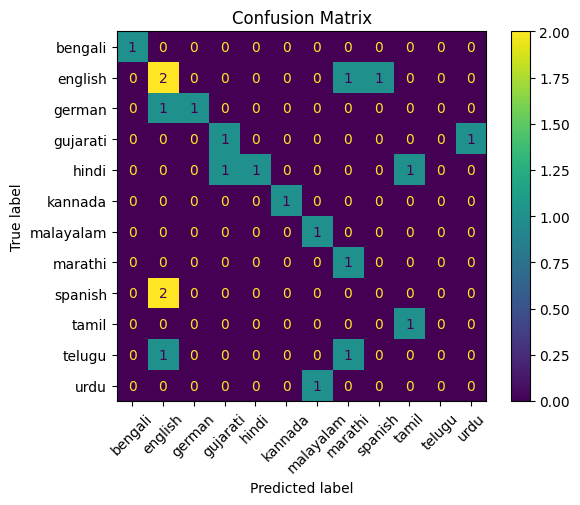

In [15]:
X_test_scaled = StandardScaler().fit_transform(X_test.reshape(-1, 58 * 431)).reshape(-1, 58, 431, 1)

model = load_model('../data/models/language_detection_model_scaled_v2.keras')
print(model.evaluate(X_test_scaled, y_test))

y_pred = model.predict(X_test_scaled)

y_test_argmax = [np.argmax(y_test[i,:]) for i in range(0, len(y_test))]
y_pred_argmax = [np.argmax(y_pred[i,:]) for i in range(0,len(y_pred))]

confusion_matrix_data = confusion_matrix(y_test_argmax, y_pred_argmax)

plt.figure(figsize = (8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=language_labels_cols)
cmd.plot()

plt.title('Confusion Matrix')
plt.xticks(rotation=45)

#### Ensembling of Models

In [16]:
def ensemble_v1(*probabilities: np.ndarray) -> tuple:
    probabilities = np.concatenate(probabilities, axis=0).reshape(-1, probabilities[0].shape[0], probabilities[0].shape[1])

    ind_prob_prod = np.prod(probabilities, axis=0)

    argmax_prob_label = np.argmax(ind_prob_prod, axis=1)
    max_prob = np.max(ind_prob_prod, axis=1)

    return argmax_prob_label, max_prob

def ensemble_v2(*probabilities: np.ndarray) -> tuple:
    probabilities = np.concatenate(probabilities, axis=0).reshape(-1, probabilities[0].shape[0], probabilities[0].shape[1])
    ensemble_prob_list = []

    top_3_labels = np.argsort(probabilities, axis=2)[:, :, -3:][:, :, ::-1]
    top_3_prob = np.sort(-np.partition(-probabilities, 3, axis=2)[:, :, :3], axis=2)[:, :, ::-1]

    for idx in range(top_3_labels.shape[1]):
        record_labels = top_3_labels[:, idx, :]
        record_probabilities = top_3_prob[:, idx, :]

        unique_labels, label_counts = np.unique(record_labels.flatten(), return_counts=True)

        max_count = np.max(label_counts)
        most_occuring_labels = unique_labels[label_counts == max_count]

        combined_prob_dict = {}

        for label in most_occuring_labels:
            label_indices = np.argwhere(record_labels == label)
            combined_prob = np.prod(record_probabilities[label_indices[:, 0], label_indices[:, 1]])
            combined_prob_dict[label] = combined_prob

        ensemble_prob_list.append(combined_prob_dict)

    max_prob_labels_with_prob = []

    for record_probs_dict in ensemble_prob_list:
        max_prob_label = max(record_probs_dict, key=record_probs_dict.get)
        max_prob = record_probs_dict[max_prob_label]

        max_prob_labels_with_prob.append({'label': max_prob_label, 'probability': max_prob})

    labels = [record['label'] for record in max_prob_labels_with_prob]
    probs = [record['probability'] for record in max_prob_labels_with_prob]

    return labels, probs

In [17]:
X_test = pd.read_parquet('../data/model_data/test_mfcc_feature_mean_dataframe_v1.parquet')
y_test = X_test['language_label']

X_test = X_test.drop(columns=['language_label']).reset_index(drop=True).values

language_labels_cols = list(pd.get_dummies(y_test, dtype=np.int32).columns.values)

X_test = X_test.reshape(-1, 58, 1)
y_test = pd.get_dummies(y_test.values, dtype=np.int32).values

model = load_model('../data/models/language_detection_model_unscaled_v1.keras')
print(model.evaluate(X_test, y_test))

y_pred_model_1 = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.6190 - loss: 2.7233
[2.723280668258667, 0.6190476417541504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [18]:
X_test = pd.read_parquet('../data/model_data/test_mfcc_feature_mean_dataframe_v1.parquet')
y_test = X_test['language_label']

X_test = X_test.drop(columns=['language_label']).reset_index(drop=True).values

language_labels_cols = list(pd.get_dummies(y_test, dtype=np.int32).columns.values)

X_test = X_test.reshape(-1, 58, 1)
y_test = pd.get_dummies(y_test.values, dtype=np.int32).values

X_test_scaled = StandardScaler().fit_transform(X_test.reshape(-1, 58)).reshape(-1, 58, 1)

model = load_model('../data/models/language_detection_model_scaled_v1.keras')
print(model.evaluate(X_test_scaled, y_test))

y_pred_model_2 = model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6190 - loss: 3.8319
[3.8318867683410645, 0.6190476417541504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


In [19]:
X_test = pd.read_parquet('../data/model_data/test_mfcc_feature_dataframe_v1.parquet')
y_test = X_test['language_label']

X_test = X_test.drop(columns=['language_label']).reset_index(drop=True).values

language_labels_cols = list(pd.get_dummies(y_test, dtype=np.int32).columns.values)

X_test = X_test.reshape(-1, 58, 431, 1)
y_test = pd.get_dummies(y_test.values, dtype=np.int32).values

model = load_model('../data/models/language_detection_model_unscaled_v2.keras')
print(model.evaluate(X_test, y_test))

y_pred_model_3 = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3810 - loss: 3.1699
[3.1698672771453857, 0.380952388048172]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


In [20]:
X_test = pd.read_parquet('../data/model_data/test_mfcc_feature_dataframe_v1.parquet')
y_test = X_test['language_label']

X_test = X_test.drop(columns=['language_label']).reset_index(drop=True).values

language_labels_cols = list(pd.get_dummies(y_test, dtype=np.int32).columns.values)

X_test = X_test.reshape(-1, 58, 431, 1)
y_test = pd.get_dummies(y_test.values, dtype=np.int32).values

X_test_scaled = StandardScaler().fit_transform(X_test.reshape(-1, 58 * 431)).reshape(-1, 58, 431, 1)

model = load_model('../data/models/language_detection_model_scaled_v2.keras')
print(model.evaluate(X_test_scaled, y_test))

y_pred_model_4 = model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.4762 - loss: 14.0349
[14.03489875793457, 0.4761904776096344]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


In [21]:
labels_v1, prob_v1 = ensemble_v1(y_pred_model_1, y_pred_model_2)
labels_v2, prob_v2 = ensemble_v2(y_pred_model_1, y_pred_model_2)

0.6190476190476191


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'bengali'),
  Text(1, 0, 'english'),
  Text(2, 0, 'german'),
  Text(3, 0, 'gujarati'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'kannada'),
  Text(6, 0, 'malayalam'),
  Text(7, 0, 'marathi'),
  Text(8, 0, 'spanish'),
  Text(9, 0, 'tamil'),
  Text(10, 0, 'telugu'),
  Text(11, 0, 'urdu')])

<Figure size 800x600 with 0 Axes>

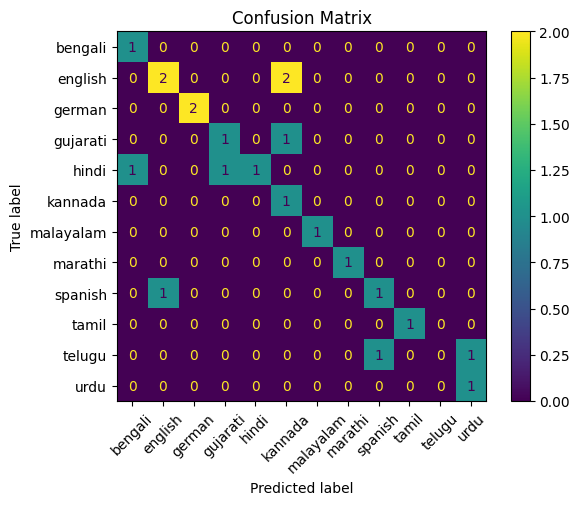

In [22]:
y_test_argmax = [np.argmax(y_test[i,:]) for i in range(0, len(y_test))]
y_pred_argmax = list(labels_v1)

print(accuracy_score(y_test_argmax, y_pred_argmax))

confusion_matrix_data = confusion_matrix(y_test_argmax, y_pred_argmax)

plt.figure(figsize = (8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=language_labels_cols)
cmd.plot()

plt.title('Confusion Matrix')
plt.xticks(rotation=45)

0.6190476190476191


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'bengali'),
  Text(1, 0, 'english'),
  Text(2, 0, 'german'),
  Text(3, 0, 'gujarati'),
  Text(4, 0, 'hindi'),
  Text(5, 0, 'kannada'),
  Text(6, 0, 'malayalam'),
  Text(7, 0, 'marathi'),
  Text(8, 0, 'spanish'),
  Text(9, 0, 'tamil'),
  Text(10, 0, 'telugu'),
  Text(11, 0, 'urdu')])

<Figure size 800x600 with 0 Axes>

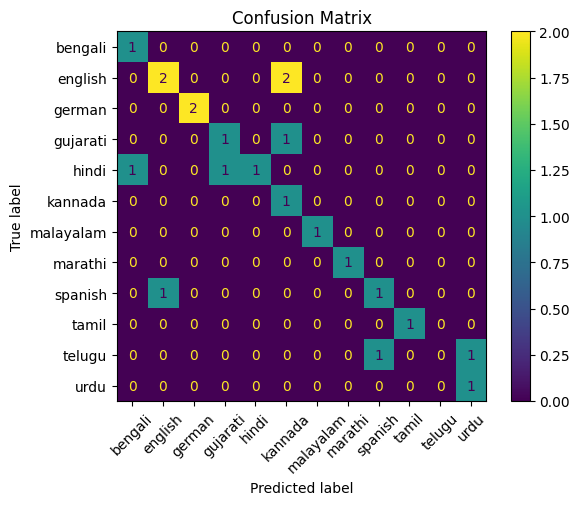

In [23]:
y_test_argmax = [np.argmax(y_test[i,:]) for i in range(0, len(y_test))]
y_pred_argmax = list(labels_v2)

print(accuracy_score(y_test_argmax, y_pred_argmax))

confusion_matrix_data = confusion_matrix(y_test_argmax, y_pred_argmax)

plt.figure(figsize = (8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=language_labels_cols)
cmd.plot()

plt.title('Confusion Matrix')
plt.xticks(rotation=45)